In [37]:
# importing all the required libraries
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


In [7]:
def extract_features(file_name):
    try:
        audio_data, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_fast')

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0)

        # Extract Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_mean = np.mean(mel.T, axis=0)

        # Extract Tempo (Rhythm)
        onset_env = librosa.onset.onset_strength(y=audio_data, sr=sample_rate)
        tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sample_rate)[0]

        # Combine all features into a single array
        features = np.hstack([mfccs_mean, chroma_mean, mel_mean, tempo])
        return features
    
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, Error: {e}")
        return None


In [26]:
data_dir = '.\Data'
genres = os.listdir(data_dir)

features_list = []
labels_list = []

for genre in genres:
    genre_dir = os.path.join(data_dir, genre)
    if os.path.isdir(genre_dir):
        for file in os.listdir(genre_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(genre_dir, file)
                features = extract_features(file_path)
                if features is not None:
                    features_list.append(features)
                    labels_list.append(genre)

# Convert to pandas DataFrame
features_df = pd.DataFrame(features_list)
labels_df = pd.DataFrame(labels_list, columns=['label'])
dataset = pd.concat([features_df, labels_df], axis=1, ignore_index=True)


In [29]:
# Column names for MFCCs, Chroma, Mel, and Tempo
mfcc_names = [f'mfcc_{i+1}' for i in range(13)]
chroma_names = [f'chroma_{i+1}' for i in range(12)]
mel_names = [f'mel_{i+1}' for i in range(128)]
tempo_name = ['tempo']


# Combine all column names
feature_column_names = mfcc_names + chroma_names + mel_names + tempo_name + ['Genre']

# Assign column names to the features DataFrame
dataset.columns = feature_column_names


In [234]:
X = dataset.drop(columns=['Genre'])
y = dataset['Genre']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Encode labels to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [238]:
# Initialize the XGBoost classifier
xgb = XGBClassifier(colsample_bytree= 0.61,   # L1 regularization term
    learning_rate= 0.0625, max_depth= 6, min_child_weight= 1, n_estimators= 270, subsample= 0.71, eval_metrics='mlogloss')

# Train the model
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)],# Validation set
    verbose=True)

# Predict on test data
y_pred = xgb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')



[0]	validation_0-mlogloss:2.21610
[1]	validation_0-mlogloss:2.13741


c:\Users\Swarupa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-mlogloss:2.06090
[3]	validation_0-mlogloss:2.00573
[4]	validation_0-mlogloss:1.95997
[5]	validation_0-mlogloss:1.91477
[6]	validation_0-mlogloss:1.86646
[7]	validation_0-mlogloss:1.82232
[8]	validation_0-mlogloss:1.78554
[9]	validation_0-mlogloss:1.75083
[10]	validation_0-mlogloss:1.71925
[11]	validation_0-mlogloss:1.68337
[12]	validation_0-mlogloss:1.65709
[13]	validation_0-mlogloss:1.63237
[14]	validation_0-mlogloss:1.60412
[15]	validation_0-mlogloss:1.58073
[16]	validation_0-mlogloss:1.55832
[17]	validation_0-mlogloss:1.53539
[18]	validation_0-mlogloss:1.51510
[19]	validation_0-mlogloss:1.49368
[20]	validation_0-mlogloss:1.47849
[21]	validation_0-mlogloss:1.46263
[22]	validation_0-mlogloss:1.44535
[23]	validation_0-mlogloss:1.42871
[24]	validation_0-mlogloss:1.41225
[25]	validation_0-mlogloss:1.39739
[26]	validation_0-mlogloss:1.38012
[27]	validation_0-mlogloss:1.36370
[28]	validation_0-mlogloss:1.34842
[29]	validation_0-mlogloss:1.33498
[30]	validation_0-mlogloss:1

              precision    recall  f1-score   support

       Blues       0.54      0.70      0.61        20
   Classical       0.87      1.00      0.93        13
     Country       0.78      0.52      0.62        27
       Disco       0.65      0.62      0.63        21
      HipHop       0.56      0.60      0.58        15
        Jazz       0.83      0.86      0.84        22
       Metal       0.85      0.92      0.88        25
         Pop       0.67      0.77      0.71        13
      Reggae       0.71      0.52      0.60        23
        Rock       0.48      0.52      0.50        21

    accuracy                           0.69       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200



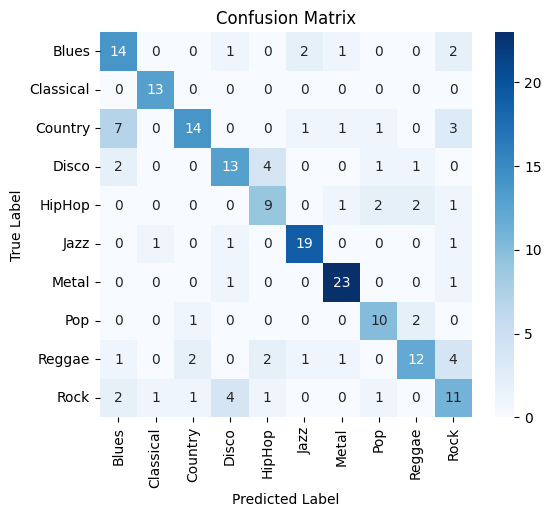

In [244]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Load dataset
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Blues','Classical','Country','Disco','HipHop','Jazz','Metal','Pop','Reggae','Rock'],
            yticklabels=['Blues','Classical','Country','Disco','HipHop','Jazz','Metal','Pop','Reggae','Rock'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [276]:
# List of genres
genres = ['Blues', 'Classical', 'Country', 'Disco', 'HipHop', 
          'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']

# Assuming xgb is your trained model and X_test is your test data
prediction = xgb.predict(X_test[[34]])

# Get the genre name from the prediction
predicted_genre = genres[prediction[0]]

print(predicted_genre)
xgb.save_model("model.pkl")

Disco


c:\Users\Swarupa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
